In [1]:
import pandas as pd
import os

def add_flag_columns(file_list):
    """
    Read multiple CSV files and add SF flag and cordon flag columns based on ISRM values.
    Makes sure to convert ISRM values to integers.
    Special handling for '_all.csv' files: renames 'Unnamed: 0' to 'ISRM'.
    
    Parameters:
    file_list (list): List of CSV filenames to process
    
    Returns:
    dict: Dictionary with filenames as keys and processed DataFrames as values
    """
    # Define the ranges
    cordon_ranges = [(1346, 1350), (1378, 1382), (1393, 1397), (1402, 1402), (1412, 1415)]
    SF_ranges = [(983, 986), (988, 991), (1002, 1005), (1039, 1048),
                 (1064, 1073), (1084, 1093), (1129, 1138), (1176, 1185),
                 (1221, 1230), (1253, 1264), (1291, 1302), (1340, 1345),
                 (1351, 1351), (1372, 1377), (1383, 1383), (1388, 1392),
                 (1407, 1411), (1416, 1416), (1053, 1053), (1113, 1113),
                 (1193, 1193)]
    
    # Helper functions to check if ISRM is in range
    def is_in_cordon(isrm_value):
        # Convert to integer if it's a string or float
        try:
            isrm = int(float(isrm_value))
            return any(start <= isrm <= end for start, end in cordon_ranges)
        except (ValueError, TypeError):
            # If conversion fails, return False
            print(f"Warning: Could not convert ISRM value '{isrm_value}' to integer")
            return False
    
    def is_in_SF(isrm_value):
        # Convert to integer if it's a string or float
        try:
            isrm = int(float(isrm_value))
            return any(start <= isrm <= end for start, end in SF_ranges)
        except (ValueError, TypeError):
            # If conversion fails, return False
            print(f"Warning: Could not convert ISRM value '{isrm_value}' to integer")
            return False
    
    # Dictionary to store processed dataframes
    processed_dfs = {}
    
    # Process each file
    for filename in file_list:
        try:
            # Read the CSV file
            print(f"Reading {filename}...")
            df = pd.read_csv(filename)
            
            # Special handling for '_all.csv' files
            if filename.endswith('_all.csv'):
                if 'Unnamed: 0' in df.columns:
                    print(f"Renaming 'Unnamed: 0' to 'ISRM' in {filename}")
                    df = df.rename(columns={'Unnamed: 0': 'ISRM'})
            
            # Check if ISRM column exists
            if 'ISRM' not in df.columns:
                # Try to find column with similar name (case insensitive)
                isrm_col = None
                for col in df.columns:
                    if 'isrm' in col.lower():
                        isrm_col = col
                        break
                
                if isrm_col:
                    print(f"Found ISRM column as '{isrm_col}' in {filename}")
                else:
                    print(f"Error: No ISRM column found in {filename}")
                    print(f"Available columns: {df.columns.tolist()}")
                    continue
            else:
                isrm_col = 'ISRM'
            
            # Print information about the ISRM column
            print(f"ISRM column data type: {df[isrm_col].dtype}")
            print(f"First 5 ISRM values: {df[isrm_col].head(5).tolist()}")
            
            # Add flag columns
            print(f"Adding flag columns to {filename}...")
            df['cordon_flag'] = df[isrm_col].apply(is_in_cordon)
            df['SF_flag'] = df[isrm_col].apply(is_in_SF)
            
            # Print summary of flags
            num_cordon = df['cordon_flag'].sum()
            num_sf = df['SF_flag'].sum()
            print(f"Added {num_cordon} cordon flags and {num_sf} SF flags to {filename}")
            
            # Save the processed dataframe to the dictionary
            processed_dfs[filename] = df
            
            # Optionally save the processed file
            output_filename = filename.replace('.csv', '_processed.csv')
            df.to_csv(output_filename, index=False)
            print(f"Saved processed file as {output_filename}")
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    return processed_dfs


if __name__ == "__main__":
    files_to_process = [
        "flat_all.csv", 
        "income_all.csv", 
        "flat_baseline_delta.csv", 
        "income_baseline_delta.csv",
        "baseline_baseline_delta.csv"
    ]
    
result = add_flag_columns(files_to_process)

Reading flat_all.csv...
Renaming 'Unnamed: 0' to 'ISRM' in flat_all.csv
ISRM column data type: int64
First 5 ISRM values: [0, 1, 2, 3, 4]
Adding flag columns to flat_all.csv...
Added 20 cordon flags and 124 SF flags to flat_all.csv
Saved processed file as flat_all_processed.csv
Reading income_all.csv...
Renaming 'Unnamed: 0' to 'ISRM' in income_all.csv
ISRM column data type: int64
First 5 ISRM values: [0, 1, 2, 3, 4]
Adding flag columns to income_all.csv...
Added 20 cordon flags and 124 SF flags to income_all.csv
Saved processed file as income_all_processed.csv
Reading flat_baseline_delta.csv...
ISRM column data type: int64
First 5 ISRM values: [843, 909, 910, 911, 912]
Adding flag columns to flat_baseline_delta.csv...
Added 20 cordon flags and 106 SF flags to flat_baseline_delta.csv
Saved processed file as flat_baseline_delta_processed.csv
Reading income_baseline_delta.csv...
ISRM column data type: int64
First 5 ISRM values: [843, 909, 910, 911, 912]
Adding flag columns to income_base

In [2]:
def load_processed_dataframes():
    """
    Reads all processed CSV files into memory as pandas DataFrames.
    
    Returns:
    dict: Dictionary with descriptive keys and DataFrames as values
    """
    # Expected processed file names
    processed_files = [
        "flat_all_processed.csv",
        "income_all_processed.csv", 
        "flat_baseline_delta_processed.csv", 
        "income_baseline_delta_processed.csv",
        "baseline_baseline_delta_processed.csv"
    ]
    
    # Dictionary to store the DataFrames
    dataframes = {}
    
    # Read each file into a DataFrame
    for filename in processed_files:
        try:
            # Check if file exists
            if not os.path.exists(filename):
                print(f"Warning: {filename} not found")
                continue
                
            # Read the CSV file
            print(f"Loading {filename}...")
            df = pd.read_csv(filename)
            
            # Print basic information about the loaded DataFrame
            print(f"Loaded {filename}: {df.shape[0]} rows, {df.shape[1]} columns")
            
            # Create a descriptive key by removing '_processed.csv'
            key = filename.replace('_processed.csv', '')
            
            # Add the DataFrame to the dictionary
            dataframes[key] = df
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
    
    # Print summary of loaded dataframes
    print("\nLoaded DataFrames summary:")
    for key, df in dataframes.items():
        print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")
        # Count SF and cordon flags if they exist
        if 'SF_flag' in df.columns and 'cordon_flag' in df.columns:
            sf_count = df['SF_flag'].sum()
            cordon_count = df['cordon_flag'].sum()
            print(f"  - SF flags: {sf_count} ({sf_count/df.shape[0]:.1%})")
            print(f"  - Cordon flags: {cordon_count} ({cordon_count/df.shape[0]:.1%})")
    
    return dataframes

dfs = load_processed_dataframes()
    

Loading flat_all_processed.csv...
Loaded flat_all_processed.csv: 52411 rows, 12 columns
Loading income_all_processed.csv...
Loaded income_all_processed.csv: 52411 rows, 12 columns
Loading flat_baseline_delta_processed.csv...
Loaded flat_baseline_delta_processed.csv: 1781 rows, 11 columns
Loading income_baseline_delta_processed.csv...
Loaded income_baseline_delta_processed.csv: 1781 rows, 11 columns
Loading baseline_baseline_delta_processed.csv...
Loaded baseline_baseline_delta_processed.csv: 1781 rows, 11 columns

Loaded DataFrames summary:
flat_all: 52411 rows, 12 columns
  - SF flags: 124 (0.2%)
  - Cordon flags: 20 (0.0%)
income_all: 52411 rows, 12 columns
  - SF flags: 124 (0.2%)
  - Cordon flags: 20 (0.0%)
flat_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon flags: 20 (1.1%)
income_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon flags: 20 (1.1%)
baseline_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon fl

In [3]:
df_flat_all = dfs['flat_all']
df_flat_all.columns.to_list()

['ISRM',
 'SOA',
 'pNO3',
 'pNH4',
 'pSO4',
 'PrimaryPM25',
 'TotalPM25',
 'deathsK',
 'deathsL',
 'geometry',
 'cordon_flag',
 'SF_flag']

In [4]:
import numpy as np

def calculate_summary_statistics(dataframes_dict):
    """
    For 'flat_all' and 'income_all' dataframes, calculates summary statistics 
    for all numeric columns at different levels based on the SF and cordon flags,
    including a new level for rows that are neither in cordon nor SF.
    
    Parameters:
    dataframes_dict (dict): Dictionary with dataframe names as keys and pandas DataFrames as values
    
    Returns:
    dict: Dictionary with dataframe names as keys and summary statistics DataFrames as values
    """
    summary_results = {}
    
    # Process only 'flat_all' and 'income_all' dataframes
    for df_name in ['flat_all', 'income_all']:
        if df_name not in dataframes_dict:
            print(f"Warning: {df_name} not found in the provided dictionary")
            continue
        
        df = dataframes_dict[df_name]
        
        # Check if required flag columns exist
        if 'SF_flag' not in df.columns or 'cordon_flag' not in df.columns:
            print(f"Warning: Required flag columns not found in {df_name}")
            continue
        
        # Get numeric columns excluding geometry and flag columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col not in ['cordon_flag', 'SF_flag']]
        
        # Initialize results dictionary
        results = {}
        
        # Calculate total level (all rows)
        total_sums = df[numeric_cols].sum().to_dict()
        results['Total'] = total_sums
        
        # Calculate SF level (where SF_flag is True)
        sf_sums = df[df['SF_flag'] == True][numeric_cols].sum().to_dict()
        results['SF'] = sf_sums
        
        # Calculate cordon level (where cordon_flag is True)
        cordon_sums = df[df['cordon_flag'] == True][numeric_cols].sum().to_dict()
        results['Cordon'] = cordon_sums
        
        # Calculate total minus cordon level (where cordon_flag is False)
        non_cordon_sums = df[df['cordon_flag'] == False][numeric_cols].sum().to_dict()
        results['Non-Cordon'] = non_cordon_sums
        
        # NEW: Calculate total minus both cordon and SF level
        # (where neither cordon_flag nor SF_flag is True)
        neither_mask = (df['cordon_flag'] == False) & (df['SF_flag'] == False)
        neither_sums = df[neither_mask][numeric_cols].sum().to_dict()
        results['Neither-Cordon-nor-SF'] = neither_sums
        
        # Convert results to DataFrame for easier viewing
        summary_df = pd.DataFrame(results).T
        
        # Add row counts
        total_count = len(df)
        sf_count = df['SF_flag'].sum()
        cordon_count = df['cordon_flag'].sum()
        non_cordon_count = total_count - cordon_count
        neither_count = neither_mask.sum()
        
        summary_df['Row_Count'] = [total_count, sf_count, cordon_count, non_cordon_count, neither_count]
        
        # Store the summary DataFrame in the results dictionary
        summary_results[df_name] = summary_df
        
        print(f"Generated summary statistics for {df_name}")
    
    return summary_results


if __name__ == "__main__":

    dfs = load_processed_dataframes()
    
    # Calculate summary statistics
    summaries = calculate_summary_statistics(dfs)
    
    # Print results
    for df_name, summary_df in summaries.items():
        print(f"\nSummary for {df_name}:")
        print(summary_df)
        

        summary_df.to_csv(f"{df_name}_summary.csv")
        print(f"Saved summary to {df_name}_summary.csv")

Loading flat_all_processed.csv...
Loaded flat_all_processed.csv: 52411 rows, 12 columns
Loading income_all_processed.csv...
Loaded income_all_processed.csv: 52411 rows, 12 columns
Loading flat_baseline_delta_processed.csv...
Loaded flat_baseline_delta_processed.csv: 1781 rows, 11 columns
Loading income_baseline_delta_processed.csv...
Loaded income_baseline_delta_processed.csv: 1781 rows, 11 columns
Loading baseline_baseline_delta_processed.csv...
Loaded baseline_baseline_delta_processed.csv: 1781 rows, 11 columns

Loaded DataFrames summary:
flat_all: 52411 rows, 12 columns
  - SF flags: 124 (0.2%)
  - Cordon flags: 20 (0.0%)
income_all: 52411 rows, 12 columns
  - SF flags: 124 (0.2%)
  - Cordon flags: 20 (0.0%)
flat_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon flags: 20 (1.1%)
income_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon flags: 20 (1.1%)
baseline_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon fl

In [5]:
def calculate_delta_statistics(dataframes_dict):
    """
    Processes baseline delta files and creates summary tables with spatial aggregations,
    plus derived comparisons between income_baseline_delta and flat_baseline_delta versus baseline_baseline_delta.
    
    Parameters:
    dataframes_dict (dict): Dictionary with dataframe names as keys and pandas DataFrames as values
    
    Returns:
    dict: Dictionary with table names as keys and summary statistics DataFrames as values
    """
    summary_results = {}
    
    # Process delta dataframes
    delta_files = ['baseline_baseline_delta', 'flat_baseline_delta', 'income_baseline_delta']
    
    for df_name in delta_files:
        if df_name not in dataframes_dict:
            print(f"Warning: {df_name} not found in the provided dictionary")
            continue
        
        df = dataframes_dict[df_name]
        
        # Check if required flag columns exist
        if 'SF_flag' not in df.columns or 'cordon_flag' not in df.columns:
            print(f"Warning: Required flag columns not found in {df_name}")
            continue
        
        # Get numeric columns excluding geometry and flag columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [col for col in numeric_cols if col not in ['cordon_flag', 'SF_flag']]
        
        # Initialize results dictionary
        results = {}
        
        # Calculate total level (all rows)
        total_sums = df[numeric_cols].sum().to_dict()
        results['Total'] = total_sums
        
        # Calculate SF level (where SF_flag is True)
        sf_sums = df[df['SF_flag'] == True][numeric_cols].sum().to_dict()
        results['SF'] = sf_sums
        
        # Calculate cordon level (where cordon_flag is True)
        cordon_sums = df[df['cordon_flag'] == True][numeric_cols].sum().to_dict()
        results['Cordon'] = cordon_sums
        
        # Calculate total minus cordon level (where cordon_flag is False)
        non_cordon_sums = df[df['cordon_flag'] == False][numeric_cols].sum().to_dict()
        results['Non-Cordon'] = non_cordon_sums
        
        # Calculate total minus both cordon and SF level
        neither_mask = (df['cordon_flag'] == False) & (df['SF_flag'] == False)
        neither_sums = df[neither_mask][numeric_cols].sum().to_dict()
        results['Neither-Cordon-nor-SF'] = neither_sums
        
        # Convert results to DataFrame for easier viewing
        summary_df = pd.DataFrame(results).T
        
        # Add row counts
        total_count = len(df)
        sf_count = df['SF_flag'].sum()
        cordon_count = df['cordon_flag'].sum()
        non_cordon_count = total_count - cordon_count
        neither_count = neither_mask.sum()
        
        summary_df['Row_Count'] = [total_count, sf_count, cordon_count, non_cordon_count, neither_count]
        
        # Store the summary DataFrame in the results dictionary
        summary_results[df_name] = summary_df
        
        print(f"Generated summary statistics for {df_name}")
    
    # Create derived comparisons if all necessary dataframes are available
    required_dfs = ['baseline_baseline_delta', 'income_baseline_delta', 'flat_baseline_delta']
    if all(df_name in summary_results for df_name in required_dfs):
        # Get baseline dataframe for reference
        baseline_df = summary_results['baseline_baseline_delta']
        
        # No need to calculate the absolute difference, as income_baseline_delta and flat_baseline_delta
        # are already differences compared to some baseline
        
        # For reference, keep the absolute values
        income_abs = summary_results['income_baseline_delta']
        summary_results['income_vs_baseline'] = income_abs
        
        flat_abs = summary_results['flat_baseline_delta']
        summary_results['flat_vs_baseline'] = flat_abs
        
        # Calculate percentage change for income vs baseline
        # This is income_baseline_delta / baseline_baseline_delta
        income_pct_change = pd.DataFrame(index=income_abs.index, columns=income_abs.columns)
        for col in income_abs.columns:
            if col == 'Row_Count':
                income_pct_change[col] = income_abs[col]
            else:
                # Calculate percentage change as a ratio (not difference)
                income_pct_change[col] = income_abs[col] / baseline_df[col] * 100
                # Replace infinities with NaN
                income_pct_change[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        summary_results['income_vs_baseline_pct'] = income_pct_change
        print("Generated income_baseline percentage change versus baseline")
        
        # Calculate percentage change for flat vs baseline
        # This is flat_baseline_delta / baseline_baseline_delta
        flat_pct_change = pd.DataFrame(index=flat_abs.index, columns=flat_abs.columns)
        for col in flat_abs.columns:
            if col == 'Row_Count':
                flat_pct_change[col] = flat_abs[col]
            else:
                # Calculate percentage change as a ratio (not difference)
                flat_pct_change[col] = flat_abs[col] / baseline_df[col] * 100
                # Replace infinities with NaN
                flat_pct_change[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        summary_results['flat_vs_baseline_pct'] = flat_pct_change
        print("Generated flat_baseline percentage change versus baseline")
    else:
        print("Warning: Could not create all derived comparisons due to missing dataframes")
    
    return summary_results


if __name__ == "__main__":

    dfs = load_processed_dataframes()
    
    # Calculate delta statistics
    delta_summaries = calculate_delta_statistics(dfs)
    
    # Print and save results
    for table_name, summary_df in delta_summaries.items():
        print(f"\nSummary for {table_name}:")
        print(summary_df)
        

        summary_df.to_csv(f"{table_name}_summary.csv")
        print(f"Saved summary to {table_name}_summary.csv")

Loading flat_all_processed.csv...
Loaded flat_all_processed.csv: 52411 rows, 12 columns
Loading income_all_processed.csv...
Loaded income_all_processed.csv: 52411 rows, 12 columns
Loading flat_baseline_delta_processed.csv...
Loaded flat_baseline_delta_processed.csv: 1781 rows, 11 columns
Loading income_baseline_delta_processed.csv...
Loaded income_baseline_delta_processed.csv: 1781 rows, 11 columns
Loading baseline_baseline_delta_processed.csv...
Loaded baseline_baseline_delta_processed.csv: 1781 rows, 11 columns

Loaded DataFrames summary:
flat_all: 52411 rows, 12 columns
  - SF flags: 124 (0.2%)
  - Cordon flags: 20 (0.0%)
income_all: 52411 rows, 12 columns
  - SF flags: 124 (0.2%)
  - Cordon flags: 20 (0.0%)
flat_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon flags: 20 (1.1%)
income_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon flags: 20 (1.1%)
baseline_baseline_delta: 1781 rows, 11 columns
  - SF flags: 106 (6.0%)
  - Cordon fl

/var/folders/s0/c3wmlnq101j6d2dv5gj15fkm0000gn/T/ipykernel_3244/111486701.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
/var/folders/s0/c3wmlnq101j6d2dv5gj15fkm0000gn/T/ipykernel_3244/111486701.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
/var/folders/s0/c3wmlnq101j6d2dv5gj15fkm0000gn/T/ipykernel_3244/111486701.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)


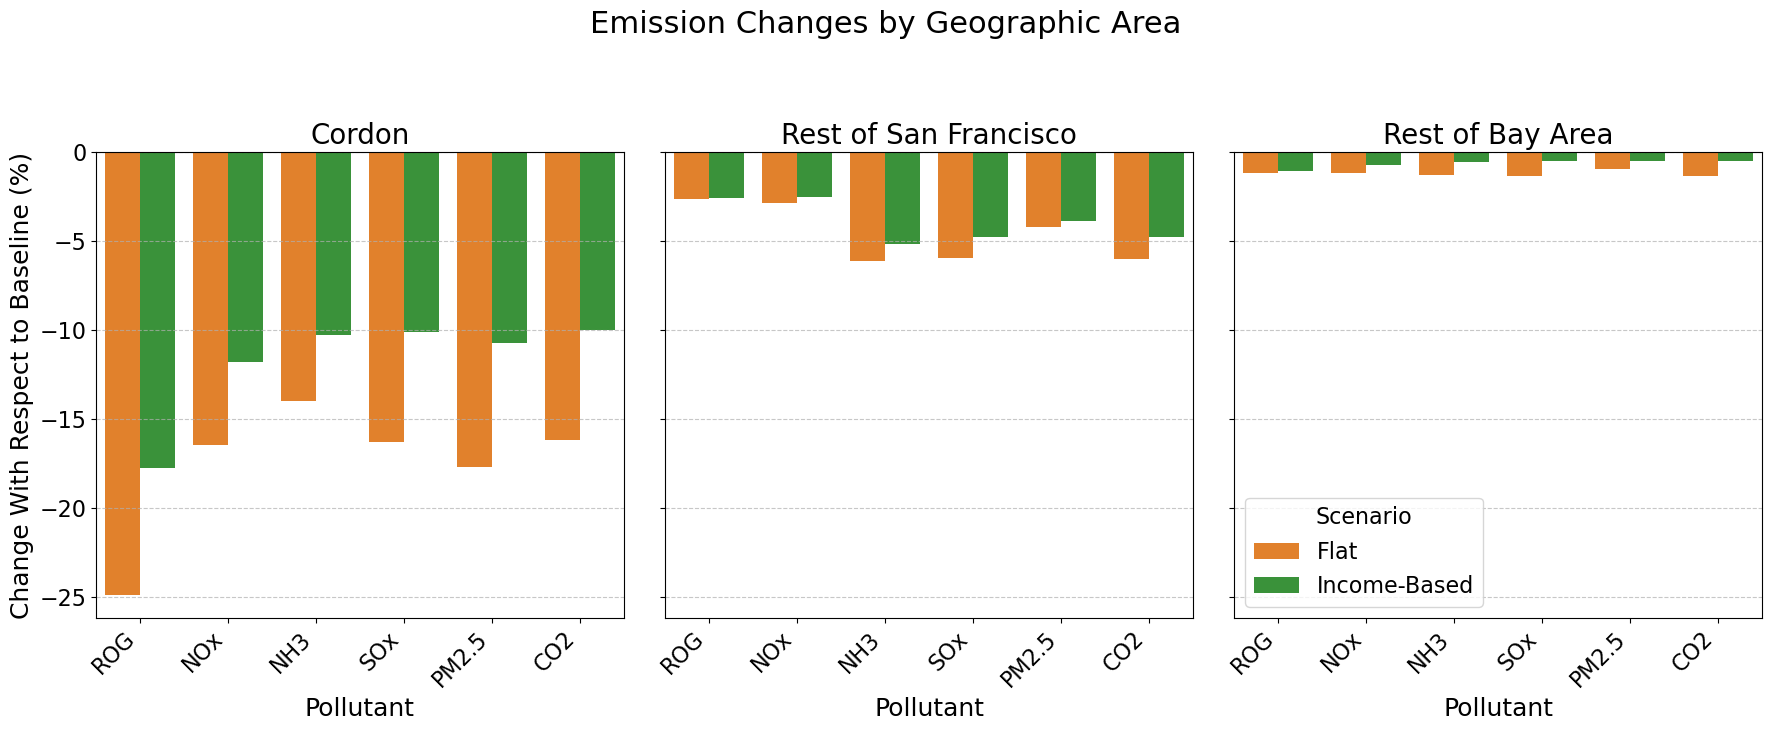

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_separate_emissions_plots(income_pct_df, flat_pct_df, emissions_cols=None, geo_levels=None, figsize=(18, 7)):
    """
    Creates three separate bar charts comparing emissions changes across scenarios,
    with one chart for each geographic level.
    """
    # Default geographic levels if not specified (in the order requested)
    if geo_levels is None:
        geo_levels = ['Cordon', 'SF', 'Neither-Cordon-nor-SF']
        
    # Mapping for display labels
    geo_level_labels = {
        'Cordon': 'Cordon',
        'SF': 'Rest of San Francisco',
        'Neither-Cordon-nor-SF': 'Rest of Bay Area'
    }
    
    # Default emissions columns if not specified (all columns containing 'tons_per_year')
    if emissions_cols is None:
        emissions_cols = [col for col in income_pct_df.columns if 'tons_per_year' in col]
    
    # Create a cleaner names mapping for the emissions
    emissions_names = {
        'tons_per_year_ROG': 'ROG',
        'tons_per_year_NOx': 'NOx',
        'tons_per_year_NH3': 'NH3',
        'tons_per_year_SOx': 'SOx',
        'tons_per_year_PM2_5': 'PM2.5',
        'tons_per_year_CO2': 'CO2'
    }
    
    # Prepare data for plotting
    plot_data = []
    
    for geo_level in geo_levels:
        for col in emissions_cols:
            # Get values for income and flat scenarios
            income_val = income_pct_df.loc[geo_level, col]
            flat_val = flat_pct_df.loc[geo_level, col]
            
            # Use cleaner name if available
            emission_name = emissions_names.get(col, col)
            
            # Add to plot data
            plot_data.append({
                'Geographic Level': geo_level,
                'Geographic Display': geo_level_labels.get(geo_level, geo_level),
                'Pollutant': emission_name,
                'Income-Based Scenario (% change)': income_val,
                'Flat Scenario (% change)': flat_val
            })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Set the font size for all text elements
    plt.rcParams.update({'font.size': 16})
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
    
    # Set overall title
    fig.suptitle('Emission Changes by Geographic Area', fontsize=22, y=1.05)
    
    # Create a plot for each geographic level
    for i, geo_level in enumerate(geo_levels):
        ax = axes[i]
        
        # Filter data for this geographic level
        geo_data = plot_df[plot_df['Geographic Level'] == geo_level]
        
        # Reshape for plotting - Flat scenario first
        geo_data_long = pd.melt(
            geo_data, 
            id_vars=['Geographic Level', 'Geographic Display', 'Pollutant'],
            value_vars=['Flat Scenario (% change)', 'Income-Based Scenario (% change)'],
            var_name='Scenario',
            value_name='Percentage Change'
        )
        
        # Simplify scenario names for legend
        geo_data_long['Scenario'] = geo_data_long['Scenario'].str.replace(' Scenario (% change)', '')
        
        # Create the bar plot
        sns.barplot(
            data=geo_data_long,
            x='Pollutant',
            y='Percentage Change',
            hue='Scenario',
            ax=ax,
            palette=['#ff7f0e','#2ca02c']  # Green for Flat, Orange for Income-based
        )
        
        # Set title and labels with increased font size
        ax.set_title(geo_data['Geographic Display'].iloc[0], fontsize=20)
        ax.set_xlabel('Pollutant', fontsize=18)
        
        if i == 0:
            ax.set_ylabel('Change With Respect to Baseline (%)', fontsize=18)
        else:
            ax.set_ylabel('')
        
        # Rotate x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
        # Add horizontal line at 0
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Add horizontal grid lines to make it easier to read values
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Data labels have been removed as requested
        
        # Only keep one legend (on the last plot)
        if i < 2:
            ax.get_legend().remove()
        else:
            # Increase legend font size
            legend = ax.get_legend()
            for text in legend.get_texts():
                text.set_fontsize(16)
            # Add a title to the legend
            legend.set_title('Scenario', prop={'size': 16})
    
    # Adjust layout
    plt.tight_layout()
    
    return fig


income_pct_df = pd.read_csv('income_vs_baseline_pct_summary.csv', index_col=0)
flat_pct_df = pd.read_csv('flat_vs_baseline_pct_summary.csv', index_col=0)
fig = create_separate_emissions_plots(income_pct_df, flat_pct_df)
plt.savefig('emissions_separate_plots.png', dpi=300, bbox_inches='tight')
plt.show()